# Intro

Hi there!

On this notebook we will focus on actually using the package and not just understanding it in a basic level.
We will plot both particles trajectories as well as generate a heatmap for the Markov prediction based on our imported data.

Let's begin.



# Trajectories

We will work on getting this image:
![trajectories%20output%20with%20dates.png](attachment:../Images/trajectories%20output%20with%20dates.png)


## Getting started

As discussed in the previous guide, we will need 4 array parameters in order to use the package as intended - x,y,t,id.
We will first import our basic packages used and then modify the data and time vaules:

### Imports

In [1]:
import sys
import copy
import netCDF4 as nc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection
import cmocean
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

from datetime import datetime as dt, timedelta as td # Used for the date and time conversion to datenum

sys.path.insert(0, '../')
from pygtm.physical import physical_space
from pygtm.matrix import matrix_space
from pygtm.dataset import trajectory # This is the original version of dateset with no oversampling
from pygtm.dataset2 import trajectory as trajectory2 # This is the oversampeling version of dataset 

### Datenum conversion

In [2]:
# Convert a stripped date to a datenum using datetime as dt
def datenum(stripped_date):
    days = 365 + d.toordinal()
    hours = (stripped_date - dt.fromordinal(d.toordinal())).total_seconds()/(24*60*60)
    return days + hours

d = dt.strptime('29/01/2018 01:00','%d/%m/%Y %H:%M')
start_time = datenum(d)

# Print for example
print(start_time)


# Reverse function for your comfort and validation, using datetime as dt and timedelta as td
def numdate(num):
    days = num - 365
    whole_days = int(days)
    fractional_days = days - whole_days
    date = dt.fromordinal(whole_days)
    time_delta = td(seconds=fractional_days * 24 * 60 * 60)
    return date + time_delta

# Print for example
num = 737088.0416666666
reveresed_date = numdate(num)
print(reveresed_date)

737088.0416666666
2018-01-29 00:59:59.999997


### Data preparation and cleanup

In [3]:
# Loading the file and reading the dataset for the particle locations, change it based on the file location locally
Med_particle = '../Data/EMed300m_his_prt_data_bc_winter.nc' 

# Creating a dataset
ds_Med_particle = nc.Dataset(Med_particle)

# Reading and naming the variables 
lon_par = ds_Med_particle['lon'][:]
lat_par = ds_Med_particle['lat'][:]
id_par = ds_Med_particle['trajectory'][:] # Acts as an ID as the data matches - if something changes with this field it needs to be reevaluated
time_par = ds_Med_particle['time'][:]

# For the time list - we will create a list starting from 0 and raising by 2/24 at each step, with a length of 418. 
# Starting with the start time defined above
time_jump = (2/24) 
time_list = np.arange(0, 418) * time_jump + start_time

# Print the following to see the list created
# print(time_list)

# Create empty lists to store data
d_id = []
x = []
y = []
t = []

# Loop through each particle - through the 10,000
for i in range(time_par[:, 0].size):
    # Append trajectory ID
    d_id.append(id_par[i].compressed().tolist())
    
    # Append longitude
    x.append(lon_par[i].compressed().tolist())
    
    # Append latitude
    y.append(lat_par[i].compressed().tolist())
    
    # Append corresponding times (using the same list for all particles)
    t.append(time_list)

# Concatenate lists to create arrays
d_id = np.concatenate(d_id)
x = np.concatenate(x)
y = np.concatenate(y)
t = np.concatenate(t)

# Print sizes for debugging, they should all be the same size (4180000)
# print(d_id.size, x.size, y.size, t.size)


We can now create our data:

In [4]:
# creates segments ready to plot with add_collection()
data = trajectory2(x,y,t,d_id)

## Segmentation through filtering

For plotting the trajectories, we will need to create segments for the particles.
We will use the `trajectory` function from `dataset` for that.

We will need to selected the area for plotting the trajectory. <br>

### Range parameters
Let's define the needed parameters for it - `x_range`, `y_range` and `t_range`.

In [5]:
# t_range
t0 = time_list[0] # first value
tf = time_list[-1] # last value
t_range = [t0,tf]

# x_range and y_range
x_range=[31, 37]
y_range=[31, 37]


### data.filtering() 
We will create some segmentations values from the `data.filtering()` function as follows:
- segs [Ns, 2, 2]: list of segments to construct a LineCollection object
                - i: segment number (Ns)
                - j: coordinates of the beginning (0) or end (1) of the segment i
                - k: longitude (0) or latitude (1) of the coordiates j
- segs_t [Ns]: time associated to each segments 
- sid [Nt,2]: indices of the first and last segment of a trajectory
         ex: trajectory 0 contains the segs[sid[0,0]:sid[0,1]]

Note:
- complete_track=False: provides a partial route - only *after* it reaches the region and not the full trajectories. If the full track is within range - it will provide a full track.

**IMPORTANT:** Please note this part takes the most amount of time to run, so if you are only intereseted in push forward then SKIP this part (it's not a requirement for it)

In [6]:
segs, segs_t, sid = data.filtering(x_range, y_range, t_range, complete_track=False)

### Plotting
Now let's plot a complete view of all the particles trajectories over time.

We will create a gradient bar for time progression and convert the datenum to dates.

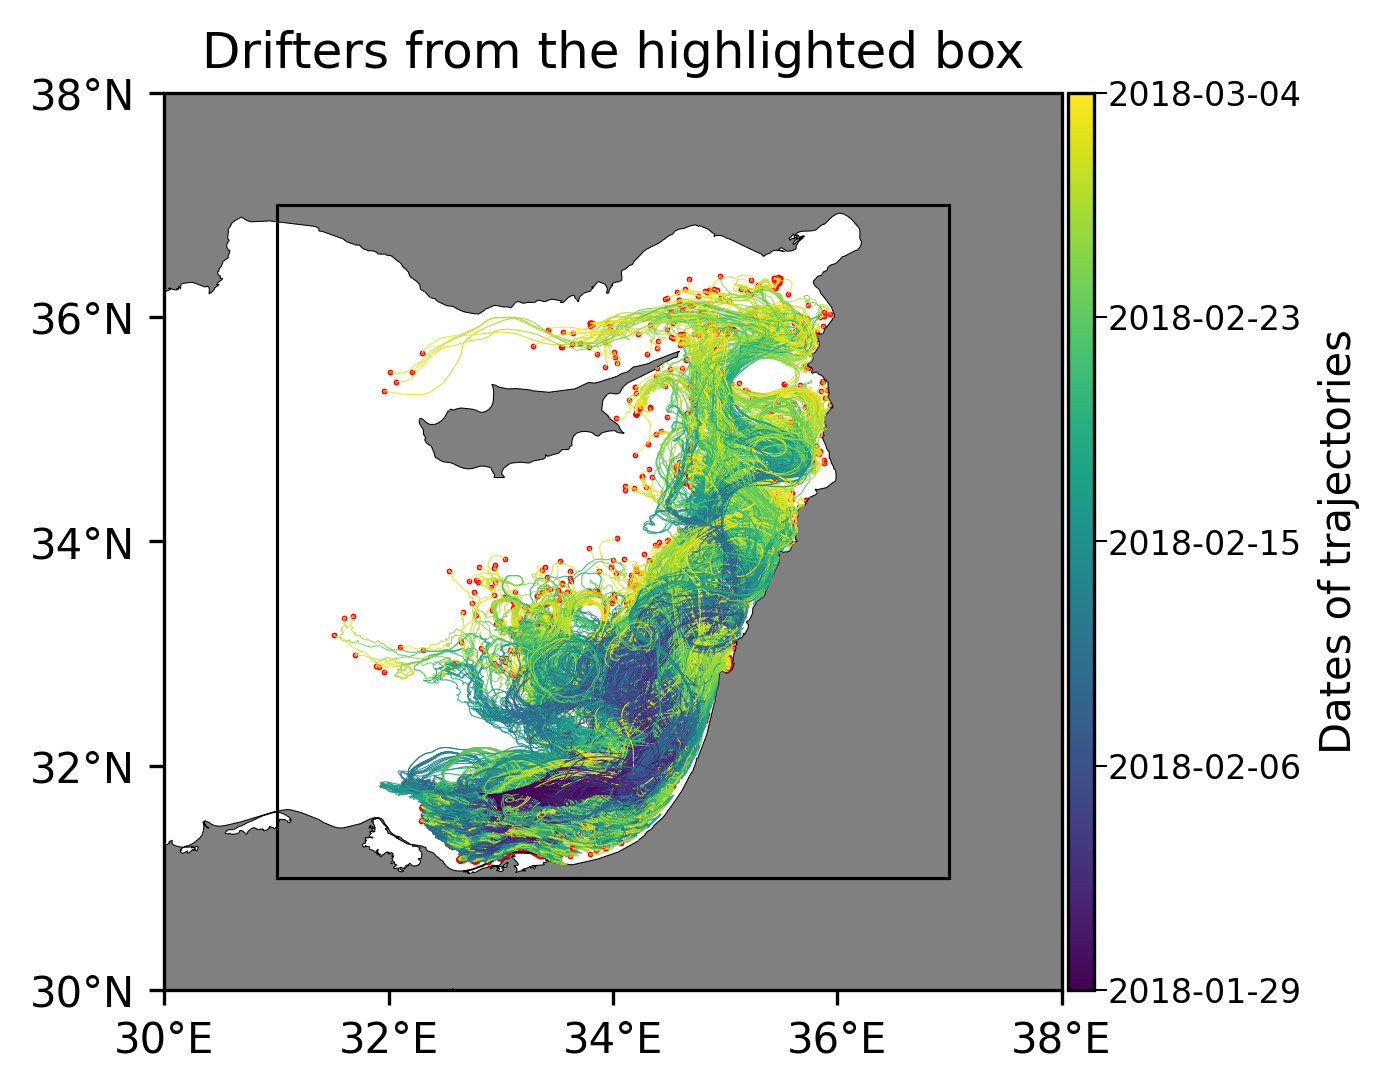

In [25]:
# ignore deprecation warning
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# plotting on a geographical map using cartopy
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')


# scatter of start/finish point
ax.scatter(segs[sid[:,0], 0, 0], segs[sid[:,0], 0, 1], s=0.15, color='b', zorder=1) # initial point of each trajectory
ax.scatter(segs[sid[:,1]-1, 1, 0], segs[sid[:,1]-1, 1, 1], s=0.15, color='r', zorder=1) # final point of each trajectory

# trajectory segments
segments = LineCollection(segs, transform=ccrs.PlateCarree(), linewidths=0.25)
segments.set_array(segs_t)
ax.add_collection(segments)

# plot box filtering zone
p = Rectangle((x_range[0], y_range[0]), np.diff(x_range), np.diff(y_range), 
              fill=False, linewidth=0.75, zorder=2)
ax.add_patch(p)

#  boundaries of area of interest
ax.set_xlim([32, 34])
ax.set_ylim([32, 34])
ax.set_title('Drifters from the highlighted box');

# ticks
ax.set_xticks([ 30,32,34,36, 38], crs=ccrs.PlateCarree())
ax.set_yticks([ 30,32,34,36, 38], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
# cb = fig.colorbar(segments, cax=cax)

# our date range
start_date = dt(2018, 1, 29)
end_date = dt(2018, 3, 4)
num_ticks = 5  # Number of ticks on the color bar

# creating a linear space of dates within the range
delta = (end_date - start_date) / (num_ticks - 1)
dates = [start_date + i * delta for i in range(num_ticks)]

# values for the color bar
values = np.arange(1, num_ticks + 1)

# normalize the values to range between 0 and 1
norm = plt.Normalize(values.min(), values.max())

# creating a ScalarMappable object using the colormap and the normalization
sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)

# creating the color bar
cb = plt.colorbar(sm, cax=cax)

# set the ticks on the color bar to the dates
cb.set_ticks(values)
cb.ax.set_yticklabels([date.strftime('%Y-%m-%d') for date in dates])

cb.ax.tick_params(which='major', labelsize=8, length=3, width=0.5, pad=0.05) ###### NEED TO CHECK IF REDUNDANT
cb.set_label('Dates of trajectories')


The above graph displays the trajectories for all of the drifters. <br>
We can also modify it and display a single trajectory, by adding an `id` parameter and modifying the code as below:

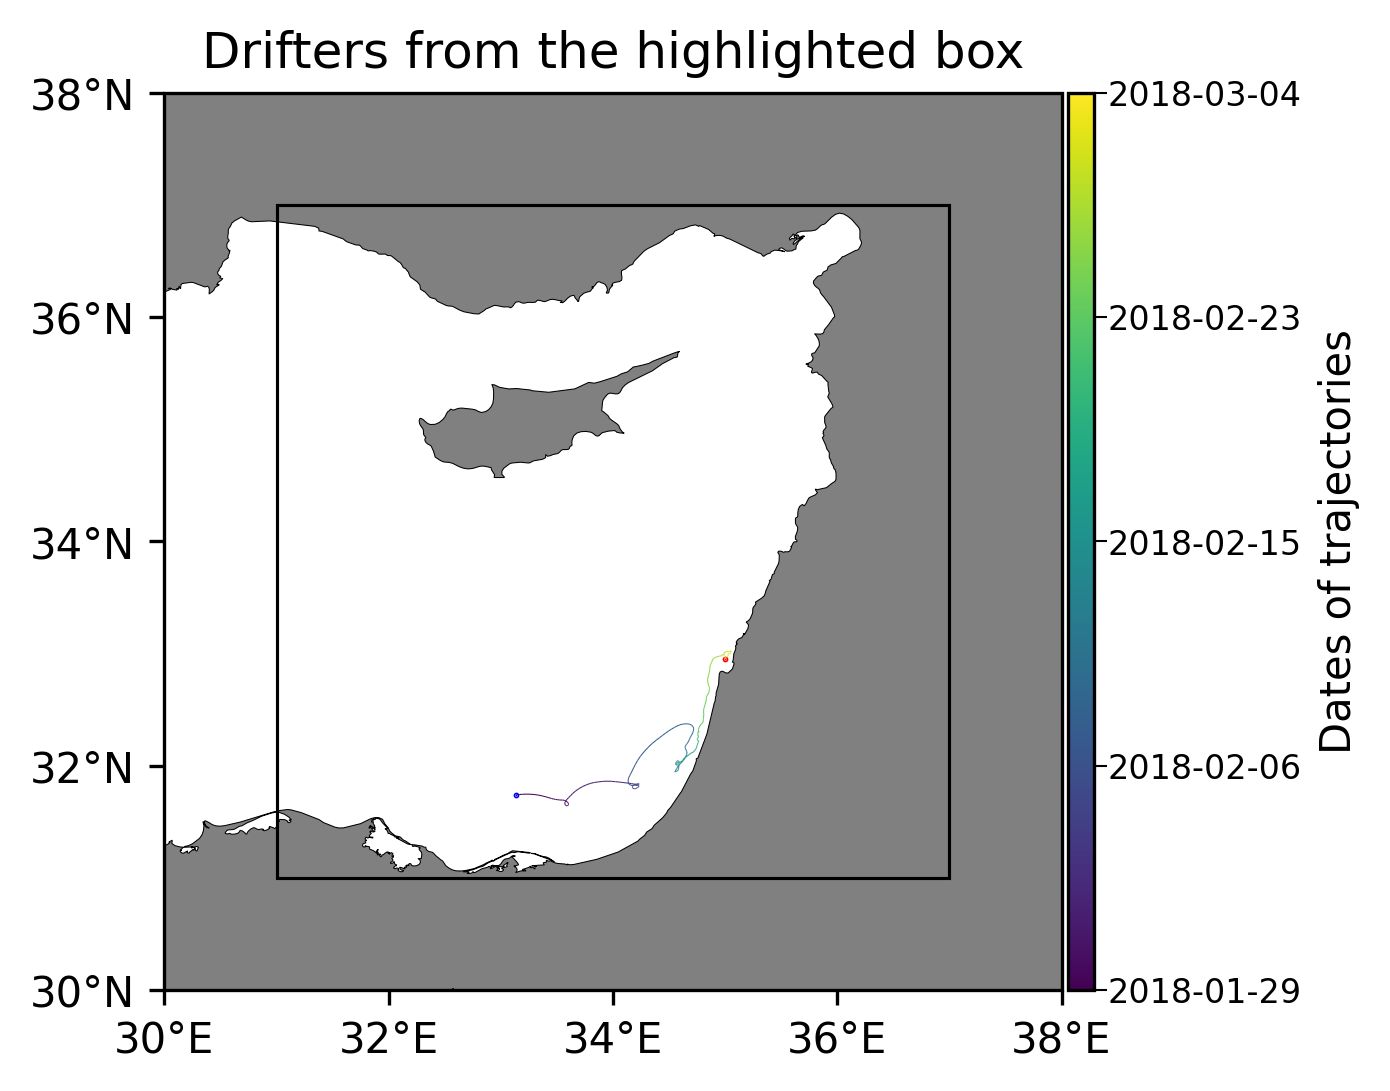

In [43]:
# plotting on a geographical map using cartopy
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

# selecting the id for the single drifter
id = 9777

# scatter of start/finish point
ax.scatter(segs[sid[id,0], 0, 0], segs[sid[id,0], 0, 1], s=0.15, color='b', zorder=1) # initial point of each trajectory
ax.scatter(segs[sid[id,1]-1, 1, 0], segs[sid[id,1]-1, 1, 1], s=0.15, color='r', zorder=1) # final point of each trajectory

# trajectory segments
segments = LineCollection(segs[sid[id,0]:sid[id,1]], transform=ccrs.PlateCarree(), linewidths=0.25)
segments.set_array(segs_t)
ax.add_collection(segments)

# plot box filtering zone
p = Rectangle((x_range[0], y_range[0]), np.diff(x_range), np.diff(y_range), 
              fill=False, linewidth=0.75, zorder=2)
ax.add_patch(p)

#  boundaries of area of interest
ax.set_xlim([32, 34])
ax.set_ylim([32, 34])
ax.set_title('Drifters from the highlighted box');

# ticks
ax.set_xticks([ 30,32,34,36, 38], crs=ccrs.PlateCarree())
ax.set_yticks([ 30,32,34,36, 38], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
# cb = fig.colorbar(segments, cax=cax)

# our date range
start_date = dt(2018, 1, 29)
end_date = dt(2018, 3, 4)
num_ticks = 5  # Number of ticks on the color bar

# creating a linear space of dates within the range
delta = (end_date - start_date) / (num_ticks - 1)
dates = [start_date + i * delta for i in range(num_ticks)]

# values for the color bar
values = np.arange(1, num_ticks + 1)

# normalize the values to range between 0 and 1
norm = plt.Normalize(values.min(), values.max())

# creating a ScalarMappable object using the colormap and the normalization
sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)

# creating the color bar
cb = plt.colorbar(sm, cax=cax)

# set the ticks on the color bar to the dates
cb.set_ticks(values)
cb.ax.set_yticklabels([date.strftime('%Y-%m-%d') for date in dates])

cb.ax.tick_params(which='major', labelsize=8, length=3, width=0.5, pad=0.05) ###### NEED TO CHECK IF REDUNDANT
cb.set_label('Dates of trajectories')


# Future Prediction 

We will work on getting this image - based on the idea of "if i look at bin i, what would be the statistical dispersion prediction after n amount of time?"

Plot explanation:
 - White area - ocean
 - Grey area - land
 - Greyed pixels - bins that at least one particle has passed through
 - Darker grayed box - starting locations of the 10,000 particles that we ran our data on
 - Blue cross - predict dispersion assuming we start at this location (X marks the spot)

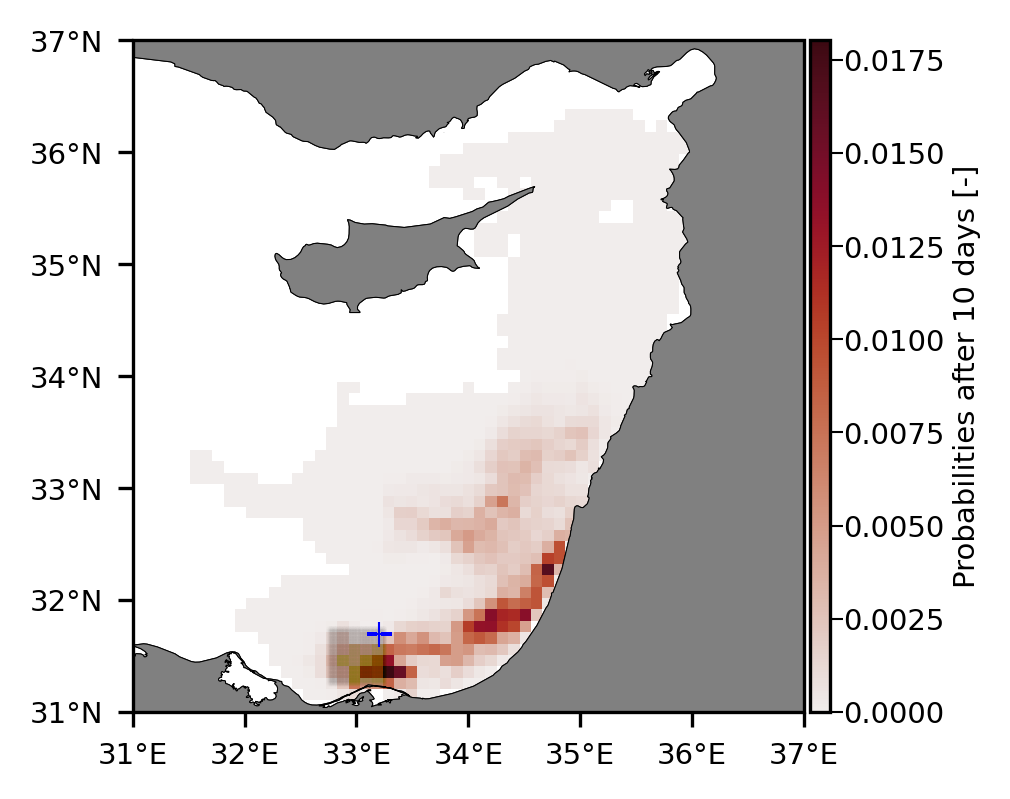

## Getting started

### Defining parameters
* T: Transition time [day]. Basically asks when to check the data, can only be full numbers. If set to 1 it checks it once a day. With oversampeling it then checks the data more, as defined. If the oversamepling value is set to 12 then it checks the data every two hours
* spatial_dis : number of bin in the the meridional direction (the number in the zonal direction is fixed to have almost square bin)
* lon : min and max longitude value of the initial domain (x axis)
* lat : min and max latitude value of the initial domain (y axis)

We will rerun `data` here just to make it clear. <br>
**NOTICE** we are using `trajectory2` here and not `trajectory`, to correct the sampling issue. <br>
You can change it to `trajectory` and see the differences in the plots created. <br>
There will be a difference in the bins numbering (as the sum changes), the bins general area (light grey) and the probabilities.

In [5]:
T = 1  # transition time [days] 
spatial_dis = 60
# changes area of view and calculation, currently set to 
lon = [31, 37] 
lat = [31, 37]

# create the grid and bins
d = physical_space(lon, lat, spatial_dis)

# creates segments ready to plot with add_collection()
data = trajectory2(x,y,t,d_id)
data.create_segments(T)

### The transition matrix

Now let's creathe the transition matrix using `fill_transition_matrix` function from `matrix_space` at `matrix` from `pygtm`

In [69]:
# create matrix object
tm = matrix_space(d)
tm.fill_transition_matrix(data)

Now, if you are wondering how this matrix looks like - we can view it using the following function. <br>
It is not required for the code to work, but enables us to see that the transition matrix is calculated once - and doesn't change where we are asking to see prediction for different times. <br>
It only depends on - x,y,t,d_id and T.

We will import pandas for this visualization.

In [70]:
import pandas as pd

def display_transition_matrix_as_table(matrix):
    df = pd.DataFrame(matrix)
    display(df)

In [71]:
transition_matrix = tm.P  # P is the transition matrix
display_transition_matrix_as_table(transition_matrix)

,0,1,2,3,4,5,6,7,8,9,...,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048
0,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00428,0.898094,0.056205,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.091558,0.767218,0.101964,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00000,0.000000,0.103728,0.689161,0.071548,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00000,0.000000,0.000000,0.096036,0.651012,0.019135,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.294118,0.705882,0.000000,0.000000,0.000000
1045,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.485714,0.514286,0.000000,0.000000
1046,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.750000,0.000000,0.000000
1047,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.302326,0.0,0.0,0.0,0.000000,0.000000,0.013953,0.088372,0.590698


As we can see, we have 1049 rows x columns - which is equivalent to the number of non empty bins we have. <br>
If we were to use `trajectory` and not `trajectory2`, we would have 1015 rows x columns as the bins number is different. <br>
We can see how many particles have passed through each bin (in total) using the following function, for another view:

In [72]:
def display_num_of_particles_per_bin(matrix):
    df = pd.DataFrame(matrix)
    display(df)

t_bins = tm.M  
display_num_of_particles_per_bin(t_bins)

,0
0,71
1,30371
2,34208
3,43537
4,41755
...,...
1044,17
1045,35
1046,4
1047,215


## Plotting

Now that we understand how the transition matrix looks and it's dependencies, we can plot the heatmap for the prediction.

We will start by creating a function for the plot:

In [73]:
# simple function to fix the axis and make plot prettier
def geo_map(ax):
    # ticks
    ax.set_xticks([31,32,33,34,35,36,37], crs=ccrs.PlateCarree())
    ax.set_yticks([31,32,33,34,35,36,37], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(axis='x', labelsize=7) 
    ax.tick_params(axis='y', labelsize=7)  


    # add land and coastline
    ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)

Now we will "push forward". <br>
The idea is "if i look at bin i, what would be the statistical dispersion prediction after n amount of time?" <br>
As so, will set an initial location (`x0,y0`) and "find bin i" and the amount (`duration`) for "n amount of time".
In order to do so, we will do the following:
- Find the initial location's matching bin using `find_element(lon=x0, lat=y0)`. The initial distribution can be set on multiple bins.
- Normalize the initial distribution sum(d0)=1
- push_forward(d0, k) performs d = d0 * P^k, for every multiplication by P, the distrution is evolve T days.

Then plot.

In [74]:
duration = 4 # days, "n amount of time"
x0 = 33 # initial location
y0 = 31.9 # initial location

In [75]:
el_id = d.find_element(x0, y0) #find matching bin for that initial location, getting "bin i"
print(el_id)

[151]


In [76]:
# setting the initial density (this always sum to 1)
density = np.zeros(len(d.bins))
density[el_id] = 1
density /= np.sum(density) # if there is more than 1 initial bin this normalize the distribution
# print(density)

In [77]:
# pushforward
evolved_density = tm.push_forward(density, int(duration / T))
# print(evolved_density)

Now we will plot it:

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16]


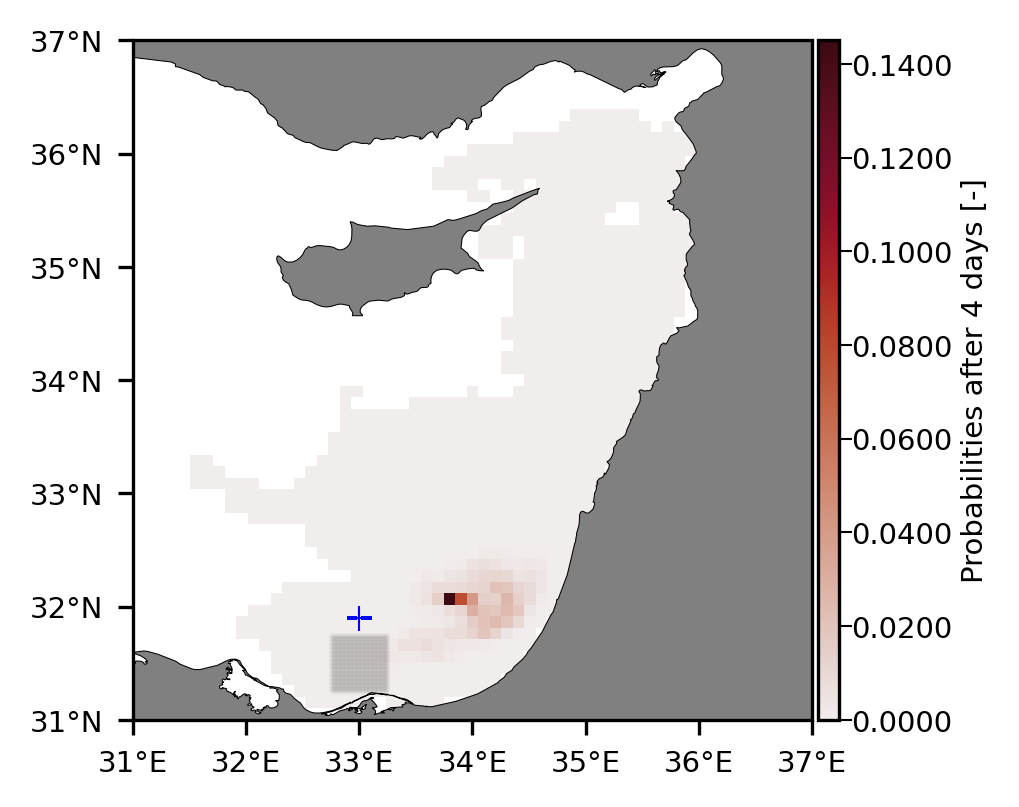

In [78]:
# ignore warning
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

# plot
fig = plt.figure(figsize=(4, 3), dpi=300)
mid_lon = (lon[0]+lon[1])/2
mid_lat = (lat[0]+lat[1])/2

# density heatmap
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')
p1 = ax1.pcolormesh(d.vx, d.vy, d.vector_to_matrix(evolved_density), cmap=cmocean.cm.amp, transform=ccrs.PlateCarree())
ax1.scatter(np.array(lon_par[:,0]), np.array(lat_par[:,0]), s=0.1, color='grey', alpha=0.005 , transform=ccrs.PlateCarree())

# mark the x0,y0 location
ax1.scatter(x0, y0, color='b', marker='+',linewidths=0.5, transform=ccrs.PlateCarree())

# colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
cb = fig.colorbar(p1, cax=cax)

# tick positions and formatting
ticks = cb.get_ticks()
print(ticks)
# cb.ax.yaxis.set_ticks(ticks)
cb.ax.set_yticklabels(['{:.4f}'.format(t) for t in ticks], fontsize=7)
cb.ax.tick_params(which='major', length=3, width=0.5, pad=0.05)

# label
cb.set_label('Probabilities after %d days [-]' % (duration), size=7, labelpad=2)

# add x,y ticks and land-sea
geo_map(ax1)


## Animating

Let's animate the plot for the above starting location. <br>
This will enable us to see the changing probabilites over time. <br>
As we have in total 34 complete days, we will have 33 frames (starting from day 1 and ending in day 34). <br>
Let's create and save the plot. <br>
We will create a folder named "pushforward_anim" and in it save the pngs in a sub-folder named by the bin id which is the `el_id` parameter.

In [65]:
# We will need to import os for this
import os

# Create the output directory if it does not exist
output_dir = f'pushforward_anim/{el_id}'
os.makedirs(output_dir, exist_ok=True)

In [66]:
for i in range(1, 35): # why 35? it excludes it in the range.
    duration = i
    evolved_density = tm.push_forward(density, int(duration / T))
    
    fig = plt.figure(figsize=(4, 3), dpi=300)
    mid_lon = (lon[0]+lon[1])/2
    mid_lat = (lat[0]+lat[1])/2

    # density heatmap
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')
    p1 = ax1.pcolormesh(d.vx, d.vy, d.vector_to_matrix(evolved_density), cmap=cmocean.cm.amp, transform=ccrs.PlateCarree())
    ax1.scatter(np.array(lon_par[:,0]), np.array(lat_par[:,0]), s=0.1, color='grey', alpha=0.005 , transform=ccrs.PlateCarree())

    # mark the x0,y0 location
    ax1.scatter(x0, y0, color='b', marker='+',linewidths=0.5, transform=ccrs.PlateCarree())

    # colorbar
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
    cb = fig.colorbar(p1, cax=cax)

    # tick positions and formatting
    ticks = cb.get_ticks()
#     cb.ax.yaxis.set_ticks(ticks)
    cb.ax.set_yticklabels(['{:.4f}'.format(t) for t in ticks], fontsize=7)
    cb.ax.tick_params(which='major', length=3, width=0.5, pad=0.05)

    # label
    cb.set_label('Probabilities after %d days [-]' % (duration), size=7, labelpad=2)

    # add x,y ticks and land-sea
    geo_map(ax1)

    
    #Save file
    output_file = os.path.join(output_dir, 'density_pushforward_%02d.png' % i)
    print('Created file:', output_file)
    plt.savefig(output_file, dpi=300)
    plt.close()  

Created file: pushforward_anim/[151]\density_pushforward_01.png
Created file: pushforward_anim/[151]\density_pushforward_02.png
Created file: pushforward_anim/[151]\density_pushforward_03.png
Created file: pushforward_anim/[151]\density_pushforward_04.png
Created file: pushforward_anim/[151]\density_pushforward_05.png
Created file: pushforward_anim/[151]\density_pushforward_06.png
Created file: pushforward_anim/[151]\density_pushforward_07.png
Created file: pushforward_anim/[151]\density_pushforward_08.png
Created file: pushforward_anim/[151]\density_pushforward_09.png
Created file: pushforward_anim/[151]\density_pushforward_10.png
Created file: pushforward_anim/[151]\density_pushforward_11.png
Created file: pushforward_anim/[151]\density_pushforward_12.png
Created file: pushforward_anim/[151]\density_pushforward_13.png
Created file: pushforward_anim/[151]\density_pushforward_14.png
Created file: pushforward_anim/[151]\density_pushforward_15.png
Created file: pushforward_anim/[151]\den

Now let's animate it:

In [67]:
# We will need to import imageio for this to create a gif - you can use other measure you know of to animate if you'd like
import imageio.v2 as imageio

# Directory containing PNG files
directory = f'pushforward_anim/{el_id}'

# Get a list of PNG files in the directory
files = [file for file in os.listdir(directory) if file.endswith('.png')]
files.sort()  # Sort files in alphabetical order

# Create a list to store images
images = []

# Read images from files and append to the list
for file in files:
    img_path = os.path.join(directory, file)
    images.append(imageio.imread(img_path))

# Save the animation
output_file = f'pushforward_anim/prediction_for_bin_{el_id}.gif'
imageio.mimsave(output_file, images, duration=1.6, loop=0)  # Adjust duration as needed

print('Done')

Done


# Summary
That's the basics of working with the pygtm package with the clean data gained through modelling particles movement in the Med Sea Eastern Basin. <br>
This is a basic example using only 10,000 particles, and can be expaneded to more particles with different starting models and more.